In [1]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import numpy as np
import pandas as pd
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import os
import json
import netCDF4
import xarray as xr
import glob
from pymms.data import util, fpi, edi, fgm
import datetime as dt
from hapiclient import hapi


import prop_data_prep as pdp
import prop_nn_models as pnn
import prop_nn_functions as pnf
import prop_MCDO_functions as MCDO
import prop_visualizations as viz
from prop_mms_data_prep import write_toDf, sweep

"""
for model
    - get efield maps
    - get mcdo error (plot as distribution?)

    
plots
- architecture diagram
- MCDO plot and dist
- shade models by errpr
- run model 5 times! cross vsalidateee

"""

'\nfor model\n    - get efield maps\n    - get mcdo error (plot as distribution?)\n\n    \nplots\n- architecture diagram\n- MCDO plot and dist\n- shade models by errpr\n- run model 5 times! cross vsalidateee\n\n'

# Model/Data Loading

In [2]:
predictors = [
    "OMNI_IMF",
    "OMNI_Vx",
    "OMNI_Vy",
    "OMNI_Vz",
    "OMNI_SYM_H",
    "L",
    "MLAT",
    "MLT",
]  # predictors, features
target = ["EX", "EY", "EZ"]  # targets, outputs

# load model
# model_floc = "prop_models/"  # directory to save model
# model_fname = "ANN_complete_EXYZ"  # model name
# model_path = model_floc + model_fname # full model path

# # load hyperparameter configuration
# f = open(model_path + "_config.json")
# CONFIG = json.load(f)

model_floc = "prop_models/"  # directory to save model
model_fname = "ANN_MODEL_N2"  # model name
model_path = model_floc + model_fname  # full model path

# load hyperparameter configuration
CONFIG = {
    "hidden_size": [1500, 1000, 500, 100, 15],  # no. of nuerons in hidden layer ;experiment
    "learning_rate": 1e-5,  # learning rate,
    "seq_len": 60,  # sequence length
    "bsize": 32,  # batch size
    "dropout_prob": 0.2,  # dropout probability
    "num_epochs": 1000,  # number of epochs
    "patience": 20,  # stop-loss function patience
    "num_features": len(predictors),  # no. of input features/variables
    "output_size": len(target),  # predicting n vars where n = len(target) array
}

# load train/test dataset
df_ds = pd.read_pickle("prop_models/complete_training_df")

# initialize the model
model = pnn.FeedForwardNN_MCDO(CONFIG['num_features'], CONFIG['seq_len'], CONFIG['hidden_size'], CONFIG['output_size'], CONFIG['dropout_prob'])
model.load_state_dict(torch.load(model_floc + model_fname))

# check
# df_ds.head(5)

<All keys matched successfully>

In [3]:
# # plot results
# preds = model(x_test_tensor).detach().numpy()

# MODEL SETUP 
# set a fixed value for the hash seed
seed=42
np.random.seed(seed)
random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
print(f"Random seed set as {seed}")

# (!) when running on the CuDNN backend, two further options must be set
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# define target and predictions variables
# x_train : feature vector (inputs) for training dataset
# y_train : target vector (outputs) for training dataset
# x_test : feature vector for testing dataset; used to evaluate models performace
# y_test : test vector for testing dataset

# during training, algorithm learns from x,y_train, adjusting to minimize error.
# performance is evaluated by x,y_test.

# split dataset into predictors (x) and target (y)
x = df_ds[predictors]
# x = df_ds[predictors].values # 5/10/24

if len(target) > 1:
    y = df_ds[target]
    # y = df_ds[target].values  # 5/10/24
    # unsure if need to add .values, results are a little different
else:
    y = df_ds[target].values.reshape(-1, 1) # for one target 

# scaling the dataset
# - (?) scale y?
# - (!) consider min/max scaler (see that one article)
x_scaler = StandardScaler()
x_scaler.fit(x.values)
x_scaled = x_scaler.transform(x)
y_scaler = StandardScaler()
y_scaler.fit(y.values)
y_scaled = y_scaler.transform(y)

# write as 3D arrays
x_scaled3d, y_scaled3d = pdp.prepare_3Darrs(x_scaled,y_scaled,lag=CONFIG['seq_len'],delay=1,next_steps=1)

# define train and test sets
#   - (!) always shuffling to best avoid cross-sampling
x_train, x_test, y_train, y_test = train_test_split(x_scaled3d, y_scaled3d, test_size=0.3, random_state=seed, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=seed, shuffle=True) # test/validation set

# covert data to torch tensors
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)
x_test_tensor = torch.Tensor(x_test)
y_test_tensor = torch.Tensor(y_test)
x_val_tensor = torch.Tensor(x_val)
y_val_tensor = torch.Tensor(y_val)


Random seed set as 42


/Users/bisola/.virtualenvs/venv-imef/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/bisola/.virtualenvs/venv-imef/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


# Plots

dimension: 11.7084295398018
dimension: 11.475264961324847
dimension: 10.284735679626465


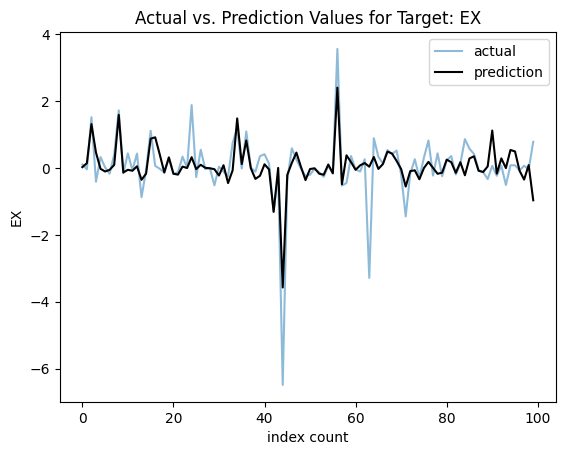

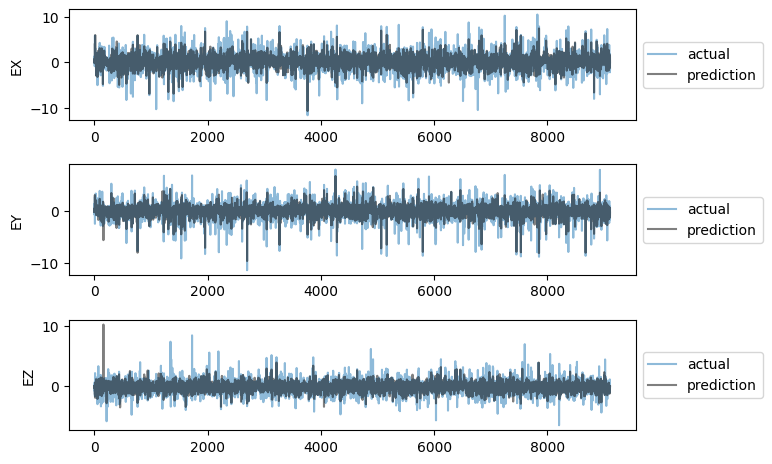

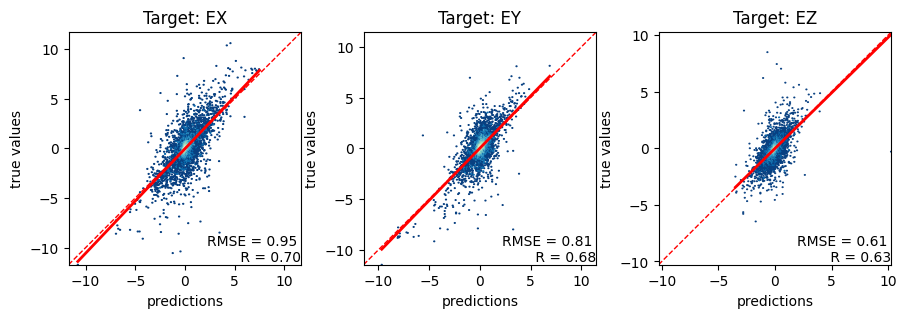

In [4]:
model.eval()
with torch.no_grad():

    preds = model(x_test_tensor).detach().numpy() # predictions (scaled)
    preds_descaled = y_scaler.inverse_transform(preds) # predictions (descaled)
    y_test_descaled = y_scaler.inverse_transform(y_test[:, -1, :]) # actual data (descaled)
    # y_out_inv = y_scaler.inverse_transform(preds)
    # y_test_inv = y_scaler.inverse_transform(y_test[:, 0])

    # target to plot
    target_indx = 0
    ix0 = 3000
    ixf = 3100

    # plot single target within index bounds of [ix0:ixf] (scale)
    viz.plot_single_pred_index(
        target[target_indx], 
        y_test[:, :, target_indx], 
        preds[:, target_indx],
        [ix0,ixf]

    )
    # plot all targets over index
    viz.plot_targets_overview(target, y_test_descaled, preds_descaled)

    # plot scatter plot of predicted vs. actual values with metrics
    hexim = viz.plot_preds_scatter(target, y_test_descaled, preds_descaled)

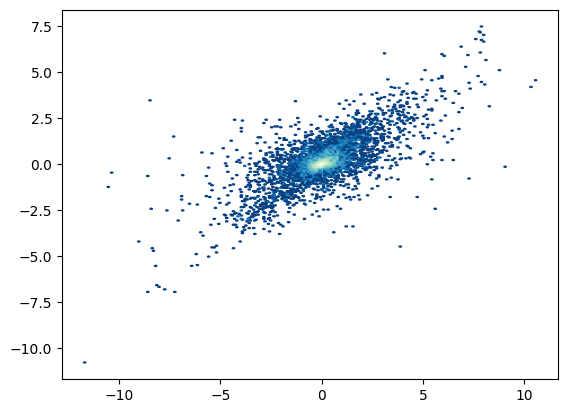

In [5]:
# 2D histogram density plot
import matplotlib as mpl

i = 0
plt.hexbin(y_test_descaled[:, i], 
           preds_descaled[:, i], 
           gridsize=(200,200),
           bins='log',
           cmap='GnBu_r')

In [6]:
# evaluate on the test set (no MC dropout)
# set model to evaluation mode and deactivate autogradient engine
model.eval()
with torch.no_grad():
    predictions = model(x_test_tensor).detach().numpy()

    for i in range(CONFIG['output_size']):
        rmse = MCDO.rmse(y_test[:, 0, i], predictions[:, i])
        corr_coef, pvalue = scipy.stats.pearsonr(y_test[:, 0, i], predictions[:, i])
        print(f"RMSE for {target[i]}: {rmse:.4f}; R = {corr_coef:.4f}")

RMSE for EX: 0.7258; R = 0.7008
RMSE for EY: 0.7358; R = 0.6797
RMSE for EZ: 0.7864; R = 0.6295


# GET TEST DATA
Goal: write functions that take some timeframe (e.g. a storm I want to test my model in) and pull dis, edi, and omni data to assemble in the same input as my model. See `imef-statistics/proposal-model/prop_mms_data_prep.py` to see how I did it with my given mms files.
* note, I was given files that contained EDI and DIS data, so all I had to do was obtain omni data and combine. DIS is not an intuitive pull, and needs to be calculated with the fpi and fgm velcoity and bfield. 

In [100]:
from hapiclient import hapi

def get_test_data(t0, tf):
    """
    Given start (t0) and end (tf) time, 
    compile a dataframe with OMNI, EDI, and DIS data

    Args:
        t0 (datetime): start time
        tf (datetime): end time

    Returns:
        _type_: _description_
    """

    # create dataframes to hold mms and omni data
    #   -(*) can eventually be written more efficiently, but needed sep dfs to testing
    # df = pd.DataFrame()
    df_mms = pd.DataFrame()
    df_omni = pd.DataFrame()

    # %%% COLLECT MMS DATA %%%

    # pull edi data using pymms
    mms_edi_data = edi.load_data(
        sc="mms1", 
        mode="srvy", 
        start_date=t0, 
        end_date=tf)

    # add time to mms df
    df_mms['time'] = mms_edi_data["Epoch"]

    # write mms data to df as individual coords
    for xyz in ['x', 'y', 'z']:
        # add edi data to df
        df_mms["E_DIS"+"_"+xyz.upper()] = mms_edi_data["E_GSE"].loc[:, "E"+xyz]

    # average data into 1 min. bins
    df_mms = df_mms.resample(rule="1Min", on="time").mean()

    # %%% COLLECT DIS DATA %%%
    # to be developed...
    # see get_dis_efield function below (currently not working, computed values don't agree with EDI)

    # %%% COLLECT OMNI data %%%

    # setup time in hapi input format
    t0_hapi = t0.strftime("%Y-%m-%d"+"T"+"%H:%M:%S")
    tf_hapi = tf.strftime("%Y-%m-%d" + "T" + "%H:%M:%S")
    print(t0_hapi) # check

    # hapi inputs
    server = "https://cdaweb.gsfc.nasa.gov/hapi"  # data server
    hapi_dataset = "OMNI_HRO2_1MIN"  # OMNI 1-minute dataset

    # params to download;
    #   - HAPI convention is that parameters is a comma-separated list
    omni_parameters = "IMF,BY_GSE,BZ_GSE,Vx,Vy,Vz,SYM_H" 

    # configuration options for the hapi function.
    opts = {"logging": True, "usecache": True, "cachedir": "./hapicache"}

    # pull omni data
    omni_data, meta = hapi(server, hapi_dataset, omni_parameters, t0_hapi, tf_hapi, **opts)

    # get var names from OMNI data in format that can be indexed
    omni_names = [s.strip() for s in omni_parameters.split(",")]

    # convert byte literal times to Python datetimes
    from hapiclient import hapitime2datetime
    omni_time = hapitime2datetime(omni_data["Time"])

    # append time
    df_omni['time'] = omni_time

    # converting the index as time
    df_omni.index = pd.to_datetime(df_omni["time"])

    # add omni data to df
    for var in omni_names:
        df_omni["OMNI_" + var] = omni_data[var]

    # combine dataframes along joint time index
    # (helps to account for missing data)
    df = pd.concat([df_mms, df_omni])

    # %%% CLEANING DATAFRAME %%%

    # # OMNI velcotiy has erroneous data where Vxyz values ~99999.9; removing those
    omni_threshold = 90000
    df[df["OMNI_Vx"] >= omni_threshold] = np.nan

    # drop rows with nans
    # (!) when applied, no data exists!
    # df.dropna(axis=0, inplace=True)

    return df

t0 = dt.datetime(2019, 3, 12, 3, 28, 0)
tf = dt.datetime(2019, 3, 18, 0, 0, 0)
df_om =  get_test_data(t0, tf)

print(df_om.shape) # mms (462,3); omni (1440,7)
df_om.head(3)


# [BI:06/13/2024]

2019-03-12T03:28:00
hapi(): Running hapi.py version 0.2.6
hapi(): file directory = ./hapicache/cdaweb.gsfc.nasa.gov_hapi
hapi(): Reading ./hapicache/cdaweb.gsfc.nasa.gov_hapi
hapi(): Writing OMNI_HRO2_1MIN___.json 
hapi(): Writing OMNI_HRO2_1MIN___.pkl 
hapi(): Reading https://cdaweb.gsfc.nasa.gov/hapi/capabilities
hapi(): Writing https://cdaweb.gsfc.nasa.gov/hapi/data?id=OMNI_HRO2_1MIN&parameters=IMF,BY_GSE,BZ_GSE,Vx,Vy,Vz,SYM_H&time.min=2019-03-12T03:28:00Z&time.max=2019-03-18T00:00:00Z&format=binary to OMNI_HRO2_1MIN_IMF,BY_GSE,BZ_GSE,Vx,Vy,Vz,SYM_H_20190312T032800_20190318T000000.bin
hapi(): Reading and parsing OMNI_HRO2_1MIN_IMF,BY_GSE,BZ_GSE,Vx,Vy,Vz,SYM_H_20190312T032800_20190318T000000.bin
hapi(): Writing ./hapicache/cdaweb.gsfc.nasa.gov_hapi/OMNI_HRO2_1MIN_IMF,BY_GSE,BZ_GSE,Vx,Vy,Vz,SYM_H_20190312T032800_20190318T000000.pkl
hapi(): Writing ./hapicache/cdaweb.gsfc.nasa.gov_hapi/OMNI_HRO2_1MIN_IMF,BY_GSE,BZ_GSE,Vx,Vy,Vz,SYM_H_20190312T032800_20190318T000000.npy
(14126, 11)


/Users/bisola/.virtualenvs/venv-imef/lib/python3.11/site-packages/hapiclient/hapitime.py:284: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


,E_DIS_X,E_DIS_Y,E_DIS_Z,time,OMNI_IMF,OMNI_BY_GSE,OMNI_BZ_GSE,OMNI_Vx,OMNI_Vy,OMNI_Vz,OMNI_SYM_H
time,,,,,,,,,,,
2019-03-12 03:28:00,-1.323150,-0.766360,0.507768,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-12 03:29:00,-0.997705,-0.228578,0.287432,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-12 03:30:00,-1.917669,-1.148580,0.825054,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
def get_dis_efield(t0,tf):
    """
    function to compute DIS efield in dataframe format.
    (!!!) Does NOT work right now! Needs fixing.

    Args:
        t0 (datetime obj.): start time
        tf (datetime obj.): end time

    Returns:
        _type_: _description_
    """
    df_E = pd.DataFrame()
    df_V = pd.DataFrame()
    df_B = pd.DataFrame()

    coords = ["x","y","z"]
    instr_label = "DIS_"

    # pull fpi dis data using pymms
    mms_dis_moms = fpi.load_moms(
        sc="mms1", 
        mode="srvy", 
        optdesc="dis-moms", 
        start_date=t0, 
        end_date=tf
    )

    # pull fgm bfield data using pymms
    mms_bfield_data = fgm.load_data(sc="mms1", 
                                mode="srvy", 
                                start_date=t0, 
                                end_date=tf)

    # start assembling dfs for velocity (V) and bfield (B)

    df_V["time"] = mms_dis_moms["time"]
    df_B["time"] = mms_bfield_data["time"]

    # write V/B to respective dfs
    for xyz in coords:
        # write bulk velcotiy V with units [km/s] to df
        df_V[f"V{xyz}"] = mms_dis_moms["velocity"].loc[:, f"V{xyz}_DBCS"]

        # write FGM magnetic field B with units [nT] to df
        df_B[f"B{xyz}"] = mms_bfield_data["B_GSE"].loc[:, f"{xyz}"] 

    # average dfs into 1 min. bins
    df_V = df_V.resample(rule="1Min", on="time").mean()
    df_B = df_B.resample(rule="1Min", on="time").mean()

    # combine dataframes along joint time index
    # (helps to account for missing data)
    df_E = df_V.join(df_B)

    # compute the cross product for each point using numpy.cross
    # multiply by factor of 1e-9 to convert to units [mV/m]
    # for xyz in coords:
    #     vval = df_E[f"V{xyz}"].values
    #     bval = df_E[f"B{xyz}"].values
    #     df_E[f"{instr_label}E{xyz}"] = -1e-9 * np.cross(vval, bval, axis=0)
    # # df_E = pd.concat([df_V,df_B], axis=1)

    # df_E['Vx'], df_E['Vx'], df_E['Vz']

    # compute the cross product for each point using numpy.cross
    df_E["Ex"] = (df_E["Vy"] * df_E["Bz"]) - (df_E["Vz"]*df_E['By'])
    df_E["Ey"] = (df_E["Vz"] * df_E["Bx"]) - (df_E["Vx"] * df_E["Bz"])
    df_E["Ez"] = (df_E["Vx"] * df_E["By"]) - (df_E["Vy"] * df_E["Bx"])
    # df_E = df_B

    # multiply by factor of 1e-9 to convert to units [mV/m]
    for xyz in coords:
        df_E[f"E{xyz}"] = -1e-9*df_E[f"E{xyz}"]

    return df_E

# sample times
# t0 = dt.datetime(2023, 4, 23, 0, 0, 0)
# tf = dt.datetime(2023, 4, 25, 0, 0, 0)

t0 = dt.datetime(2019, 3, 12, 3, 28, 0)
tf = dt.datetime(2019, 3, 18, 0, 0, 0)
df = get_dis_efield(t0, tf)
df.head(5) # why is Ez not computing??

896kB [00:01, 474kB/s]                           
1.88MB [00:03, 633kB/s]                            
384kB [00:00, 906kB/s]                           
1.62MB [00:03, 530kB/s]                            
2.00MB [00:02, 742kB/s]                            
2.12MB [00:03, 608kB/s]                            
2.12MB [00:03, 676kB/s]                            
2.12MB [00:02, 772kB/s]                            
2.12MB [00:02, 951kB/s]                             
1.75MB [00:03, 605kB/s]                            
1.75MB [00:02, 641kB/s]                            
768kB [00:00, 951kB/s]                            
49.5MB [00:07, 6.83MB/s]                            
47.2MB [00:02, 21.0MB/s]                            
74.5MB [00:02, 31.0MB/s]                            


,Vx,Vy,Vz,Bx,By,Bz,Ex,Ey,Ez
time,,,,,,,,,
2019-03-12 03:28:00,-9.521705,-42.026226,-11.447082,9.122787,25.238375,63.391342,2.375193e-06,-4.991643e-07,-1.430840e-07
2019-03-12 03:29:00,-13.138722,8.310452,8.478882,12.046106,24.337477,62.687420,-3.146062e-07,-9.257701e-07,4.198719e-07
2019-03-12 03:30:00,-11.588017,38.718594,2.773988,14.659648,20.994911,62.332756,-2.355197e-06,-7.629787e-07,8.108904e-07
2019-03-12 03:31:00,28.000868,20.394276,6.359572,14.384256,22.756474,62.193607,-1.123672e-06,1.649997e-06,-3.438445e-07
2019-03-12 03:32:00,15.451885,-5.453066,16.447721,9.948548,23.078714,62.763023,7.218431e-07,8.061760e-07,-4.108597e-07


# EFIELD MAPS
Goal:  Assemble a design matrix, and use that as input for my model, where the results can be plotted as electric field maps.

In [102]:
# inputs t0, te, imef_data
# assume nans removed
import xarray as xr

# load training dataset, since I cannot generate my own yet
imef_data = pd.read_pickle("prop_models/complete_training_df") 
time_indx = imef_data.index.values

design_matrix = []  # list to hold desigh matrix
time_matrix = []  # list to hold times assoc. with matrix values

ft = 60*5

# imef_data.where(imef_data.index>=(imef_data.index.values[0]+np.timedelta64(5, 'h')), drop=True)
targ_list = ["OMNI_IMF", "OMNI_Vx", "OMNI_Vy", "OMNI_Vz", "OMNI_SYM_H"]

for ix in range(0,len(time_indx)):
    ix_matrix_row = [] # matrix row at loop index (ix)

    # get time intervals
    # `- (!) should be end
    time_intervals = pd.date_range(start=time_indx[ix], freq="5T", periods=60)
    # print('index',time_indx)
    # print('intrvl',time_intervals)
    # try:
    # write predictors at ix to row

    for given_targ in targ_list:
        tarr = imef_data[given_targ].to_xarray()

        ix_targ = tarr.sel(time=time_intervals, method='nearest').values.tolist()
        ix_matrix_row += ix_targ # append to design matrix row

    # get location data (L, MLT, MLAT)
    loc_data = np.array(
        [imef_data["L"].values[ix],
        np.cos(np.pi / 12 * imef_data["MLT"].values[ix]),
        np.sin(np.pi / 12 * imef_data["MLT"].values[ix]),
        np.cos(imef_data["MLAT"].values[ix]),
        np.sin(imef_data["MLAT"].values[ix]),]
    )

    # write location data (np array) at ix to row (list)
    ix_matrix_row += loc_data.tolist()

    # append row to design matrix
    # print("row",ix_matrix_row)
    design_matrix.append(ix_matrix_row)

    # append times to time matrix
    time_matrix.append(time_indx[ix])

# torch tensor design matrix
design_matrix_tensor = torch.tensor(design_matrix)

# except Exception as ex:
#     pass

In [ ]:
base_symh = design_matrix_tensor[-1].clone()
number_of_inputs = len(targ_list)
size_of_input_vector = 60 * number_of_inputs + 5

for L in range(4, 11):
    for MLT in range(0, 24):
        new_row = base_symh.clone()
        new_row[-3] = L
        new_row[-2] = np.cos(np.pi / 12 * MLT)
        new_row[-1] = np.sin(np.pi / 12 * MLT)
        even_newer_row = torch.empty((1, size_of_input_vector))
        even_newer_row[0] = new_row
        if L == 4 and MLT == 0:
            all_locations = even_newer_row
        else:
            all_locations = torch.cat((all_locations, even_newer_row))

model.eval()
with torch.no_grad():
    pred = model(all_locations)

RuntimeError: shape '[168, 420]' is invalid for input of size 51240

In [ ]:
l = ["Geeks", "for", "Geeks!"]

# open file
with open("gfg.txt", "w+") as f:

    # write elements of list
    for items in l:
        f.write("%s\n" % items)

    print("File written successfully")


# close the file
f.close()

File written successfully


In [ ]:
hidden_size_arr = [[5000, 1000, 500, 100, 15], [1000, 500, 100, 15], [1000, 100, 15]]
for i in hidden_size_arr:
    print(str(i[-1]))
    i[-1]


seq_len = 60
bsize = 32
dropout_prob = 0.2
num_epochs = 1000
patience = 20


hidden_size_arr = [[5000, 1000, 500, 100, 15], [1000, 500, 100, 15], [1000, 100, 15]]
learning_rate_arr = [1e-2, 1e-4, 5e-4, 1e5, 1e-6]



15
15
15
